In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cmocean
import gsw as gsw
import matplotlib as mpl
from glob import glob
import pickle

In [2]:
# A simple smoothing functions for processing the Argo data
# when it is finer than 2m resolution.
def smooth(A):
        O = np.zeros(np.shape(A))
        for ii in range(len(A)):
            O[ii]=(1*A[max(0,ii-1)]+2*A[ii]+A[min(ii+1,len(A)-1)])/4.
        return O


In [3]:
#Path to Argo dac data
Argo_path = '/net3/bgr/Datasets/Argo/202307-ArgoData/dac/'
profile_paths = glob(Argo_path+'*/*/*_prof.nc')

LP = len(profile_paths)
print(LP,'total Argo files to parse')

# This step can count the total number of profiles accumulated through all the files.
# It can take a while, but useful to do once.
#The most recent result is: 2829732  found Argo profiles
# No subsequent blocks rely on this option being set true, it is only to know how many global Argo profiles
# were obtained.
Yes_I_Really_Want_To_Know = False

if Yes_I_Really_Want_To_Know:
    TP=0
    for IN in range(LP):
        if np.mod(IN,100)==0: print("Scanning total profiles, file: "+str(IN)+'/'+str(LP), end = "\r")
        with xr.open_dataset(profile_paths[IN]) as hndl:
            TP+=hndl.N_PROF.size
    print(TP,' found Argo profiles')

17834 total Argo files to parse


In [4]:
# This block scans through all the files and stores the filenames that have profiles close to 
# the various TAO buoys located on the equator.  These will be loaded later.  The next cell gives
# an option to dump the filename lists into a pickle file for reloading later.
# In my most recent run I have the following tally of profiles:
# Computing total profiles, file: 17800/17834
# 165e: 1316 170w: 1181 155w: 1231 140w: 1392 125w: 942 110w: 1476 95w: 1150

odir = '/net3/bgr/Datasets/Argo/MLDs/'

#Can make this into batches if we don't want to do all data at once (e.g., for testing)
BATCH=[0,LP] # 127


#We will avoid loading data outside of this box to speed it up a bit:
MinLon=-200
MaxLon=-90
delLat=0.5

#Initialize filename lists
FILENAME_LIST_165e = []
FILENAME_LIST_170w = []
FILENAME_LIST_155w = []
FILENAME_LIST_140w = []
FILENAME_LIST_125w = []
FILENAME_LIST_110w = []
FILENAME_LIST_95w = []


for IN in range(BATCH[0],BATCH[1]):
    if np.mod(IN,200)==0: 
        print("Computing total profiles, file: "+str(IN)+'/'+str(LP)) 
        TTL_165e = 0
        for ii in FILENAME_LIST_165e:
            TTL_165e+=len(ii[1])
        TTL_170w = 0
        for ii in FILENAME_LIST_170w:
            TTL_170w+=len(ii[1])
        TTL_155w = 0
        for ii in FILENAME_LIST_155w:
            TTL_155w+=len(ii[1])
        TTL_140w = 0
        for ii in FILENAME_LIST_140w:
            TTL_140w+=len(ii[1])
        TTL_125w = 0
        for ii in FILENAME_LIST_125w:
            TTL_125w+=len(ii[1])
        TTL_110w = 0
        for ii in FILENAME_LIST_110w:
            TTL_110w+=len(ii[1])
        TTL_95w = 0
        for ii in FILENAME_LIST_95w:
            TTL_95w+=len(ii[1])

        print('165e:',TTL_165e,
              '170w:',TTL_170w,
              '155w:',TTL_155w,
              '140w:',TTL_140w,
              '125w:',TTL_125w,
              '110w:',TTL_110w,
              '95w:',TTL_95w,
             )
    
    with xr.open_dataset(profile_paths[IN]) as hndl:
        if ( abs(hndl.LATITUDE).min()<delLat):
            hndl.LONGITUDE[hndl.LONGITUDE>0]-=360
            if ( (hndl.LONGITUDE.min()<MaxLon)&(hndl.LONGITUDE.max()>MinLon)&(hndl.LONGITUDE.max()<0)):
                NP = hndl.N_PROF.size
                NZ = hndl.N_LEVELS.size
                Z_c_2d       = np.zeros([NP,NZ])+np.NaN
                dCTdz_c_2d = np.zeros([NP,NZ])+np.NaN
                dRho0dz_c_2d = np.zeros([NP,NZ])+np.NaN
                GOOD_165e = np.zeros([NP],dtype=bool)
                GOOD_170w = np.zeros([NP],dtype=bool)
                GOOD_155w = np.zeros([NP],dtype=bool)
                GOOD_140w = np.zeros([NP],dtype=bool)
                GOOD_125w = np.zeros([NP],dtype=bool)
                GOOD_110w = np.zeros([NP],dtype=bool)
                GOOD_95w  = np.zeros([NP],dtype=bool)
                for p in range(NP):
                    DayQC = float(hndl.JULD_QC[p])
                    PosQC = float(hndl.POSITION_QC[p])
                    if (np.max(DayQC==np.array([1,2,5,8]))
                        and 
                        np.max(PosQC==np.array([1,2,5,8]))):

                        #QC
                        SALTQC = np.array(hndl.PSAL_QC[p,:],dtype=float)
                        TEMPQC = np.array(hndl.TEMP_QC[p,:],dtype=float)
                        PRESQC = np.array(hndl.PRES_QC[p,:],dtype=float)

                        #Computes in-situ density from T&S, T, or S

                        #Start with some quality control on the data
                        LI = (((SALTQC==1)|(SALTQC==2)|(SALTQC==5)|(SALTQC==8))
                              &
                              ((TEMPQC==1)|(TEMPQC==2)|(TEMPQC==5)|(TEMPQC==8))
                              &
                              ((PRESQC==1)|(PRESQC==2)|(PRESQC==5)|(PRESQC==8)))
                        if (np.sum(LI)>20):
                            Pressure = np.array(hndl.PRES[p,:][LI],dtype=float)
                            PSal = np.array(hndl.PSAL[p,:].values[LI],dtype=float)
                            Temp = np.array(hndl.TEMP[p,:].values[LI],dtype=float)

                            QQ = ((np.min(Pressure)>0)&(np.max(Pressure)<3000)&
                                  (np.min(PSal)>0)&(np.max(PSal)<50)&
                                  (np.min(Temp)>-2)&(np.max(Temp)<50))
                            QS = all(Pressure[z] < Pressure[z+1] for z in range(len(Pressure)-1))
                            if (QQ and QS):
                                GOOD=True
                            else:
                                GOOD=False
                        else:
                            GOOD=False
                        if GOOD:
                            if  (abs(hndl.LATITUDE[p])<delLat) & (hndl.LONGITUDE[p]>-200) & (hndl.LONGITUDE[p]<-190):
                                GOOD_165e[p]=True
                            if  (abs(hndl.LATITUDE[p])<delLat) & (hndl.LONGITUDE[p]>-175) & (hndl.LONGITUDE[p]<-165):
                                GOOD_170w[p]=True
                            if  (abs(hndl.LATITUDE[p])<delLat) & (hndl.LONGITUDE[p]>-160) & (hndl.LONGITUDE[p]<-150):
                                GOOD_155w[p]=True
                            if  (abs(hndl.LATITUDE[p])<delLat) & (hndl.LONGITUDE[p]>-145) & (hndl.LONGITUDE[p]<-135):
                                GOOD_140w[p]=True
                            if  (abs(hndl.LATITUDE[p])<delLat) & (hndl.LONGITUDE[p]>-130) & (hndl.LONGITUDE[p]<-120):
                                GOOD_125w[p]=True
                            if  (abs(hndl.LATITUDE[p])<delLat) & (hndl.LONGITUDE[p]>-115) & (hndl.LONGITUDE[p]<-105):
                                GOOD_110w[p]=True
                            if  (abs(hndl.LATITUDE[p])<delLat) & (hndl.LONGITUDE[p]>-100) & (hndl.LONGITUDE[p]<-90):
                                GOOD_95w[p]=True
                        
                FILENAME_LIST_165e += [[profile_paths[IN],list(np.arange(NP)[GOOD_165e])],]
                FILENAME_LIST_170w += [[profile_paths[IN],list(np.arange(NP)[GOOD_170w])],]
                FILENAME_LIST_155w += [[profile_paths[IN],list(np.arange(NP)[GOOD_155w])],]
                FILENAME_LIST_140w += [[profile_paths[IN],list(np.arange(NP)[GOOD_140w])],]
                FILENAME_LIST_125w += [[profile_paths[IN],list(np.arange(NP)[GOOD_125w])],]
                FILENAME_LIST_110w += [[profile_paths[IN],list(np.arange(NP)[GOOD_110w])],]
                FILENAME_LIST_95w += [[profile_paths[IN],list(np.arange(NP)[GOOD_95w])],]
                            



Computing total profiles, file: 0/17834
165e: 0 170w: 0 155w: 0 140w: 0 125w: 0 110w: 0 95w: 0
Computing total profiles, file: 200/17834
165e: 0 170w: 0 155w: 0 140w: 0 125w: 0 110w: 0 95w: 39
Computing total profiles, file: 400/17834
165e: 0 170w: 0 155w: 0 140w: 0 125w: 0 110w: 0 95w: 39
Computing total profiles, file: 600/17834
165e: 8 170w: 25 155w: 40 140w: 42 125w: 0 110w: 0 95w: 39
Computing total profiles, file: 800/17834
165e: 8 170w: 54 155w: 40 140w: 42 125w: 0 110w: 0 95w: 39
Computing total profiles, file: 1000/17834
165e: 8 170w: 54 155w: 40 140w: 42 125w: 0 110w: 0 95w: 44
Computing total profiles, file: 1200/17834
165e: 8 170w: 54 155w: 40 140w: 42 125w: 0 110w: 0 95w: 44
Computing total profiles, file: 1400/17834
165e: 8 170w: 54 155w: 40 140w: 42 125w: 0 110w: 0 95w: 44
Computing total profiles, file: 1600/17834
165e: 8 170w: 54 155w: 40 140w: 42 125w: 0 110w: 0 95w: 44
Computing total profiles, file: 1800/17834
165e: 8 170w: 54 155w: 40 140w: 42 125w: 0 110w: 1 95w: 

Computing total profiles, file: 14600/17834
165e: 1223 170w: 1147 155w: 1226 140w: 1390 125w: 921 110w: 1473 95w: 1150
Computing total profiles, file: 14800/17834
165e: 1223 170w: 1147 155w: 1226 140w: 1390 125w: 921 110w: 1473 95w: 1150
Computing total profiles, file: 15000/17834
165e: 1223 170w: 1147 155w: 1226 140w: 1390 125w: 921 110w: 1473 95w: 1150
Computing total profiles, file: 15200/17834
165e: 1223 170w: 1147 155w: 1226 140w: 1390 125w: 921 110w: 1473 95w: 1150
Computing total profiles, file: 15400/17834
165e: 1223 170w: 1147 155w: 1226 140w: 1390 125w: 921 110w: 1473 95w: 1150
Computing total profiles, file: 15600/17834
165e: 1223 170w: 1147 155w: 1226 140w: 1390 125w: 921 110w: 1473 95w: 1150
Computing total profiles, file: 15800/17834
165e: 1223 170w: 1147 155w: 1226 140w: 1390 125w: 921 110w: 1473 95w: 1150
Computing total profiles, file: 16000/17834
165e: 1223 170w: 1147 155w: 1226 140w: 1390 125w: 921 110w: 1473 95w: 1150
Computing total profiles, file: 16200/17834
165e

In [5]:
#Assuming the last block was run previously, this block writes the filename lists.

with open('../Data/TAO_0n_FilesLists.pickle', 'wb') as f:
    pickle.dump([FILENAME_LIST_165e,
                 FILENAME_LIST_170w,
                FILENAME_LIST_155w,
                FILENAME_LIST_140w,
                FILENAME_LIST_125w,
                FILENAME_LIST_110w,
                FILENAME_LIST_95w],
                f)

In [6]:
#Assuming the last block was run previously, this block reads the data from the filename lists.
# The data is then remapped into a common vertical coordinate

with open('../Data/TAO_0n_FilesLists.pickle', 'rb') as f:
    [FILENAME_LIST_165e,FILENAME_LIST_170w,FILENAME_LIST_155w,FILENAME_LIST_140w, 
     FILENAME_LIST_125w, FILENAME_LIST_110w, FILENAME_LIST_95w] = pickle.load(
        f)   

def GetProfiles(FILENAME_LIST):
    TTL = 0
    for ii in FILENAME_LIST:
        TTL+=len(ii[1])

    time=list(np.zeros(TTL))

    Z_2d=np.zeros([TTL,1500])+np.NaN
    T_2d=np.zeros([TTL,1500])+np.NaN
    dTdz_2d=np.zeros([TTL,1500])+np.NaN
    S_2d=np.zeros([TTL,1500])+np.NaN
    dSdz_2d=np.zeros([TTL,1500])+np.NaN
    N2_2d=np.zeros([TTL,1500])+np.NaN

    iii=-1
    for ii in FILENAME_LIST:
        with xr.open_dataset(ii[0]) as hndl:
            for p in ii[1]:
                iii+=1
                if (np.mod(iii,100)==0): print(1.*iii/TTL)
                SALTQC = np.array(hndl.PSAL_QC[p,:],dtype=float)
                TEMPQC = np.array(hndl.TEMP_QC[p,:],dtype=float)
                PRESQC = np.array(hndl.PRES_QC[p,:],dtype=float)

                #Computes in-situ density from T&S, T, or S

                #Start with some quality control on the data
                LI = (((SALTQC==1)|(SALTQC==2)|(SALTQC==5)|(SALTQC==8))
                      &
                      ((TEMPQC==1)|(TEMPQC==2)|(TEMPQC==5)|(TEMPQC==8))
                      &
                      ((PRESQC==1)|(PRESQC==2)|(PRESQC==5)|(PRESQC==8)))
                long=hndl.LONGITUDE[p].values
                lat=hndl.LATITUDE[p].values
                Pressure = np.array(hndl.PRES[p,:][LI],dtype=float)
                PSal = np.array(hndl.PSAL[p,:].values[LI],dtype=float)
                dP = Pressure[1]-Pressure[0]
                #PSal = smooth(PSal)
                ASal = gsw.SA_from_SP(PSal,Pressure,long,lat)
                Temp = np.array(hndl.TEMP[p,:].values[LI],dtype=float)
                #Temp = smooth(Temp)
                Rho = gsw.density.rho_t_exact(ASal,Temp,Pressure)
                
                
                
                CT = gsw.conversions.CT_from_rho(Rho,ASal,Pressure)[0]
                Rho0 = gsw.density.rho(ASal,CT,0)

                #Set a zero surface pressure bin
                P_i = np.array([0.]+list(Pressure))

                #First guess at Z_i from pressure
                Z_i = -1.*P_i
                dZ = (Z_i[:-1]-Z_i[1:])
                MULT = np.ones(np.size(dZ))
                MULT[Z_i[1:]<-200]=0
                if (np.nanmin(dZ)<=0 or 
                    np.nanmax(dZ*MULT)>=11 or #checking that upper 200 is 10m resolution
                    np.nanmax(dZ)>=60 or 
                    np.nanmin(Z_i)<-2100
                   ):
                    time[iii]=hndl.JULD[p].values

                else:
                    CT_i = np.array([CT[0]]+list(CT))
                    ASal_i = np.array([ASal[0]]+list(ASal))
                    Rho0_i = np.array([Rho0[0]]+list(Rho0))
                    Rho_i = np.array([Rho[0]]+list(Rho))
                    Pressure_i = np.array([0.,]+list(Pressure))
                    
                    
                    P_c       = 0.5*(P_i[1:]+P_i[:-1])
                    dP        = (P_i[:-1]-P_i[1:])
                    CT_c      = 0.5*(CT_i[1:]+CT_i[:-1])
                    ASal_c    = 0.5*(ASal_i[1:]+ASal_i[:-1])
                    Rho0_c    = 0.5*(Rho0_i[1:]+Rho0_i[:-1])
                    #Get density for layer from mean CT and Psal and central pressure
                    Rho = gsw.density.rho(ASal,CT_c,P_c)
                    #Compute Z_i referenced to a z=0 surface using layer mean density
                    # and assuming hydrostatic pressure
                    for zi in range(len(Rho)):
                        Z_i[zi+1]=Z_i[zi]+1.e4*dP[zi]/(9.81*Rho[zi])
                    Z_c = 0.5*(Z_i[1:]+Z_i[:-1])
                    dZ = (Z_i[:-1]-Z_i[1:])
                    dRho0dz_c = (Rho0_i[...,:-1]-Rho0_i[...,1:])/dZ
                    dCTdz_c = (CT_i[...,:-1]-CT_i[...,1:])/dZ
                    dSdz_c = (ASal_i[...,:-1]-ASal_i[...,1:])/dZ

                    #N2 needs to be computed from rho w/ central pressure.
                    Rho_i_Plo = gsw.density.rho_t_exact(ASal_i[1:],CT_i[1:],Pressure)
                    Rho_i_Pup = gsw.density.rho_t_exact(ASal_i[:-1],CT_i[:-1],Pressure)
                    N2_c = -9.81/1025*(Rho_i_Pup-Rho_i_Plo)/dZ
                    
                    LG = len(Z_c)
                    time[iii]=hndl.JULD[p].values

                    Z_2d[iii,:LG] = Z_c
                    dTdz_2d[iii,:LG] = dCTdz_c
                    T_2d[iii,:LG] = CT_c
                    dSdz_2d[iii,:LG] = dSdz_c
                    S_2d[iii,:LG] = ASal_c
                    N2_2d[iii,:LG] = N2_c
    return time,Z_2d,T_2d,dTdz_2d,S_2d,dSdz_2d,N2_2d



time_165e, Z_2d_165e,T_2d_165e,dTdz_2d_165e,S_2d_165e,dSdz_2d_165e,N2_2d_165e = GetProfiles(FILENAME_LIST_165e)
time_170w, Z_2d_170w,T_2d_170w,dTdz_2d_170w,S_2d_170w,dSdz_2d_170w,N2_2d_170w = GetProfiles(FILENAME_LIST_170w)
time_140w, Z_2d_140w,T_2d_140w,dTdz_2d_140w,S_2d_140w,dSdz_2d_140w,N2_2d_140w = GetProfiles(FILENAME_LIST_140w)
time_110w, Z_2d_110w,T_2d_110w,dTdz_2d_110w,S_2d_110w,dSdz_2d_110w,N2_2d_110w = GetProfiles(FILENAME_LIST_110w)

 
               

0.0
0.07598784194528875
0.1519756838905775
0.22796352583586627
0.303951367781155
0.3799392097264438
0.45592705167173253
0.5319148936170213
0.60790273556231
0.6838905775075987
0.7598784194528876
0.8358662613981763
0.9118541033434651
0.9878419452887538
0.0
0.0846740050804403
0.1693480101608806
0.2540220152413209
0.3386960203217612
0.42337002540220153
0.5080440304826418
0.5927180355630821
0.6773920406435224
0.7620660457239627
0.8467400508044031
0.9314140558848434
0.0
0.07183908045977011
0.14367816091954022
0.21551724137931033
0.28735632183908044
0.35919540229885055
0.43103448275862066
0.5028735632183908
0.5747126436781609
0.646551724137931
0.7183908045977011
0.7902298850574713
0.8620689655172413
0.9339080459770115
0.0
0.06775067750677506
0.13550135501355012
0.2032520325203252
0.27100271002710025
0.33875338753387535
0.4065040650406504
0.4742547425474255
0.5420054200542005
0.6097560975609756
0.6775067750677507
0.7452574525745257
0.8130081300813008
0.8807588075880759
0.948509485094851


In [7]:
def REGRID(Z_2d,T_2d,S_2d,DZ):
    REGRID_Z = np.arange(-2000,0.1,DZ)
    TTL=np.shape(Z_2d)[0]
    
    REGRID_T = np.zeros([TTL,len(REGRID_Z)])
    REGRID_S = np.zeros([TTL,len(REGRID_Z)])
    REGRID_dTdz = np.zeros([TTL,len(REGRID_Z)])
    REGRID_dSdz = np.zeros([TTL,len(REGRID_Z)])
    REGRID_N2 = np.zeros([TTL,len(REGRID_Z)])

    for ii in range(TTL):
        REGRID_T[ii,:] = np.interp(REGRID_Z,Z_2d[ii,::-1],T_2d[ii,::-1],left=np.NaN,right=np.NaN)
        REGRID_S[ii,:] = np.interp(REGRID_Z,Z_2d[ii,::-1],S_2d[ii,::-1],left=np.NaN,right=np.NaN)
        rho0 = gsw.density.rho(REGRID_S[ii,:],REGRID_T[ii,:],0)
        REGRID_dTdz[ii,:] = np.gradient(REGRID_T[ii,:],DZ)
        REGRID_dSdz[ii,:] = np.gradient(REGRID_S[ii,:],DZ)
        #N2 is approximated from the gradient of potential
        # temperature to make a fair comparison with model
        # data.
        #print(abs(Z_2d[ii,0]-Z_2d[ii,1]))
        #Argo measurements are usually preprocessed into
        #1db, 2db, or 4db vertical pressure spacing.
        #if it is 1db it is finer than the finest model
        # grid (2m) so for those cases
        # we smooth it with a 1:2:1 filter.
        if (abs(Z_2d[ii,0]-Z_2d[ii,1])<0.8*DZ):
            #print(abs(Z_2d[ii,0]-Z_2d[ii,1]))
            rho0=smooth(rho0)
        REGRID_N2[ii,:] = -np.gradient(rho0,DZ)*9.81/1025.
        
    return REGRID_T,REGRID_S,REGRID_dTdz,REGRID_dSdz, REGRID_N2

# The regridding coordinate spacing
# 2m is chosen as it is the finest resolution of the model output
# we do smoothing on higher resolution Argo data to make it
# more compatible.
dz = 2.
REGRID_T_165e, REGRID_S_165e, REGRID_dTdz_165e, REGRID_dSdz_165e, REGRID_N2_165e = REGRID(Z_2d_165e,T_2d_165e,S_2d_165e,dz)
REGRID_T_170w, REGRID_S_170w, REGRID_dTdz_170w, REGRID_dSdz_170w, REGRID_N2_170w = REGRID(Z_2d_170w,T_2d_170w,S_2d_170w,dz)
REGRID_T_140w, REGRID_S_140w, REGRID_dTdz_140w, REGRID_dSdz_140w, REGRID_N2_140w = REGRID(Z_2d_140w,T_2d_140w,S_2d_140w,dz)
REGRID_T_110w, REGRID_S_110w, REGRID_dTdz_110w, REGRID_dSdz_110w, REGRID_N2_110w = REGRID(Z_2d_110w,T_2d_110w,S_2d_110w,dz)
REGRID_Z = np.arange(-2000,0.1,dz)

            

/tmp/ipykernel_3729885/3583790052.py:40: UserWarning: The following kwargs were not used by contour: 'lineweights'
  ax.contour((X),Z,DENo,[0.05,],colors='k',lineweights=0.5,linestyles='-')
/tmp/ipykernel_3729885/3583790052.py:41: UserWarning: The following kwargs were not used by contour: 'lineweights'
  ax.contour((X),Z,DENo,[0.95,],colors='k',lineweights=0.5,linestyles='-')
/tmp/ipykernel_3729885/3583790052.py:40: UserWarning: The following kwargs were not used by contour: 'lineweights'
  ax.contour((X),Z,DENo,[0.05,],colors='k',lineweights=0.5,linestyles='-')
/tmp/ipykernel_3729885/3583790052.py:41: UserWarning: The following kwargs were not used by contour: 'lineweights'
  ax.contour((X),Z,DENo,[0.95,],colors='k',lineweights=0.5,linestyles='-')
/tmp/ipykernel_3729885/3583790052.py:40: UserWarning: The following kwargs were not used by contour: 'lineweights'
  ax.contour((X),Z,DENo,[0.05,],colors='k',lineweights=0.5,linestyles='-')
/tmp/ipykernel_3729885/3583790052.py:41: UserWarni

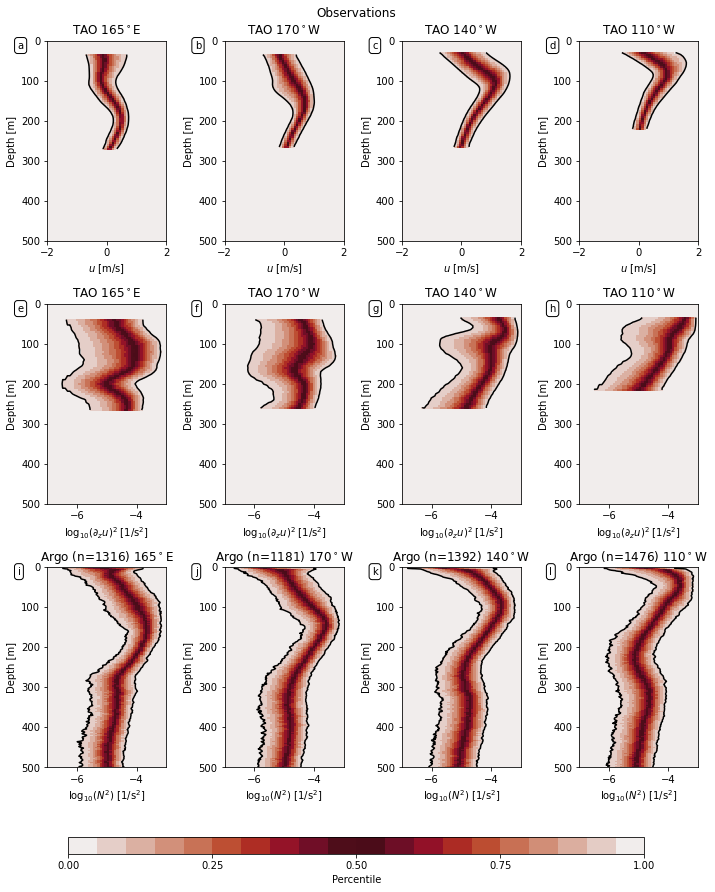

In [8]:
#This block creates Figure 5 in the submitted manuscript.
fig,AX=plt.subplots(3,4,figsize=(10,12))
colors1 = cmocean.cm.amp(np.linspace(0., 1, 128))
colors2 = cmocean.cm.amp_r(np.linspace(0, 1, 128))
colors = np.vstack((colors1, colors2))
cmap = mpl.colors.LinearSegmentedColormap.from_list('amp2amp_r', colors)
levels=np.linspace(0,1,21)

for i,Lon in enumerate(['165e','170w','140w','110w']):
    Lat='0n'

    #This block was used to load Tao current data for PDFs utilized below
    tao_path = '/net2/bgr/Data/Mooring/TAO/HiRes/'

    tao_file = glob(tao_path+'adcp'+Lat+Lon+'*')[0]
    Hobs = xr.open_dataset(tao_file).sel(time=slice('2001/01/01','2008/12/31')).isel(lat=0,lon=0)
    U=np.array(Hobs.u_1205.round(decimals=1).values.squeeze(),dtype='float')
    U[abs(U)>1.e3]=np.NaN
    Z=np.array(Hobs.depth.values,dtype='double')
    

    stnd_bins = np.linspace(-2,2,51)

    A = np.zeros([len(Z),len(stnd_bins)-1])
    CT = np.zeros(len(Z))
    for zi in range(len(Z)):
        u = U[:,zi]
        u=u[np.isfinite(u)]
        A[zi,:] = np.histogram(u/100.,stnd_bins)[0]
        CT[zi] = len(u)
    A[CT<(365*24*3),:]=np.NaN
    DENo = (np.cumsum(A,axis=1).T/np.sum(A,axis=1)).T
    X = 0.5*(stnd_bins[1:]+stnd_bins[:-1])
    
    ax=AX.ravel()[i]
    c=ax.pcolormesh((X),Z,DENo,
                  cmap=cmap,
                  norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=False)
                   )
    ax.contour((X),Z,DENo,[0.05,],colors='k',lineweights=0.5,linestyles='-')
    ax.contour((X),Z,DENo,[0.95,],colors='k',lineweights=0.5,linestyles='-')
    ax.set_ylim(500,0)
    ax.set_title('TAO '+Lon[:-1]+'$^\circ$'+Lon[-1].upper())
    ax.set_ylabel('Depth [m]')
    ax.set_xlabel('$u$ [m/s]')
    #ax.grid(True)
    ax.set_facecolor(cmocean.cm.amp(0))
    c.cmap.set_bad(cmocean.cm.amp(0))
        
stnd_bins = np.linspace(-7,-3,51)
stnd_bins = 10**stnd_bins

for i,Lon in enumerate(['165e','170w','140w','110w']):
    Lat='0n'

    #This block was used to create MeanU utilized below
    tao_path = '/net2/bgr/Data/Mooring/TAO/HiRes/'

    tao_file = glob(tao_path+'adcp'+Lat+Lon+'*')[0]
    Hobs = xr.open_dataset(tao_file).sel(time=slice('2001/01/01','2008/12/31')).isel(lat=0,lon=0)
    U=np.array(Hobs.u_1205.round(decimals=1).values.squeeze(),dtype='float')
    U[abs(U)>1.e3]=np.NaN
    Z=np.array(Hobs.depth.values,dtype='double')
    dU=np.gradient(U/100.,Z,axis=1)



    A = np.zeros([len(Z),len(stnd_bins)-1])
    CT = np.zeros(len(Z))
    for zi in range(len(Z)):
        du = dU[:,zi]
        du=du[np.isfinite(du)]
        A[zi,:] = np.histogram(du**2,stnd_bins)[0]
        CT[zi] = len(du)
    
    A[CT<(365*24*3),:]=np.NaN
    DENo = (np.cumsum(A,axis=1).T/np.sum(A,axis=1)).T

    X = 0.5*(stnd_bins[1:]+stnd_bins[:-1])

    ax=AX.ravel()[i+4]
    c=ax.pcolormesh(np.log10(X),Z,DENo,
                  cmap=cmap,
                  norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=False)
                   )
    ax.contour(np.log10(X),Z,DENo,[0.05,],colors='k',lineweights=0.5,linestyles='-')
    ax.contour(np.log10(X),Z,DENo,[0.95,],colors='k',lineweights=0.5,linestyles='-')
    ax.set_ylim(500,0)
    ax.set_title('TAO '+Lon[:-1]+'$^\circ$'+Lon[-1].upper())
    ax.set_ylabel('Depth [m]')
    ax.set_xlabel('$\log_{10}(\partial_z u)^2$ [1/s$^2$]')
    #ax.grid(True)
    ax.set_facecolor(cmocean.cm.amp(0))
    c.cmap.set_bad(cmocean.cm.amp(0))


for i,Lon in enumerate(['165e','170w','140w','110w']):
    if Lon=='165e':
        N2 = REGRID_N2_165e
    elif Lon=='170w':
        N2 = REGRID_N2_170w
    elif Lon=='140w':
        N2 = REGRID_N2_140w
    elif Lon=='110w':
        N2 = REGRID_N2_110w

    TTL = np.shape(N2)[0]

    
    Z = -REGRID_Z
    A = np.zeros([len(Z),len(stnd_bins)-1])
    CT = np.zeros(len(Z))
    for zi in range(len(Z)):
        du = N2[:,zi]
        du=du[np.isfinite(du)]
        A[zi,:] = np.histogram(du,stnd_bins)[0]
        CT[zi] = len(du)
    A[CT<(100),:]=np.NaN
    DENo = (np.cumsum(A,axis=1).T/np.sum(A,axis=1)).T

    X = 0.5*(stnd_bins[1:]+stnd_bins[:-1])

    ax=AX.ravel()[i+8]
    c=ax.pcolormesh(np.log10(X),Z,DENo,
                  cmap=cmap,
                  norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, clip=False)
                   )
    ax.contour(np.log10(X),Z,DENo,[0.05,],colors='k',lineweights=0.5,linestyles='-')
    ax.contour(np.log10(X),Z,DENo,[0.95,],colors='k',lineweights=0.5,linestyles='-')
    ax.set_ylim(500,0)
    #ax.grid(True)
    ax.set_ylabel('Depth [m]')
    #axt.set_xticklabels('')
    ax.set_xlabel('$\log_{10}(N^2)$ [1/s$^2$]')
    
    #ax.set_title('Argo Lon={:} ({:4d}'.format(Lon,TTL)+')')
    ax.set_title('Argo (n={:}) '.format(TTL)+Lon[:-1]+'$^\circ$'+Lon[-1].upper())
    
fig.suptitle('Observations')
fig.tight_layout()
fig.subplots_adjust(bottom=0.1)
axcb=fig.add_axes([0.1,0.00,0.8,0.02])
cb=plt.colorbar(c,cax=axcb,orientation='horizontal')
cb.set_ticks([0,0.25,0.5,0.75,1])
cb.set_label('Percentile')

for AXi in range(0,4):
    txt='abcdefghijklmnopqrstuvwyxz'[AXi]
    AX.ravel()[AXi].text(-3,20,txt,bbox=dict(boxstyle='round', facecolor='white'))
for AXi in range(4,12):
    txt='abcdefghijklmnopqrstuvwyxz'[AXi]
    AX.ravel()[AXi].text(-8,20,txt,bbox=dict(boxstyle='round', facecolor='white'))

fig.savefig('../Fig/Observed_Occurences.png',dpi=200,bbox_inches = "tight")
        
